In [1]:
!pip install pandas
!pip install xgboost
# !pip install --force-reinstall scikit-learn==1.2.1 imbalanced-learn==0.10.1 joblib==1.2.0
!pip install scikit-optimize
!pip install --force-reinstall numpy==1.26.4 pandas==1.5.3 scikit-learn==1.2.1 imbalanced-learn==0.10.1 joblib==1.2.0 scipy==1.10.1 threadpoolctl==3.1.0
# !pip install imblearn

  Using cached scikit_learn-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
  Using cached joblib-1.2.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 196.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 141.8 MB/s  0:00:00
Using cached scikit_learn-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 127.0 MB/s  0:00:00m0:00:01
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz

In [2]:
import numpy, pandas, sklearn, imblearn, joblib, scipy, threadpoolctl
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("joblib:", joblib.__version__)
print("scipy:", scipy.__version__)
print("threadpoolctl:", threadpoolctl.__version__)

numpy: 1.26.4
pandas: 1.5.3
scikit-learn: 1.2.1
imbalanced-learn: 0.10.1
joblib: 1.2.0
scipy: 1.10.1
threadpoolctl: 3.1.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import boto3
from skopt import BayesSearchCV
# import skops.io as skio

import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    precision_recall_curve, fbeta_score, average_precision_score, roc_auc_score,
    confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
)

import os, tarfile, time, json, sys, subprocess
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
s3 = boto3.client('s3')
bucket_name = 'medi-sagemaker-fraud-detection'
train_file_key = 'data/train/fraud_837P_train_update2.csv'
train_obj = s3.get_object(Bucket=bucket_name, Key=train_file_key)
train_df = pd.read_csv(train_obj['Body'])

val_file_key = 'data/validation/fraud_837P_val_updated2.csv'
val_obj = s3.get_object(Bucket=bucket_name, Key=val_file_key)
val_df = pd.read_csv(val_obj['Body'])

test_file_key = 'data/test/fraud_837P_test_updated2.csv'
test_obj = s3.get_object(Bucket=bucket_name, Key=test_file_key)
test_df = pd.read_csv(test_obj['Body'])


TARGET = "Fraud"

Class balance after cleaning: {'train': {0: 557, 1: 150}, 'val': {0: 119, 1: 32}, 'test': {0: 119, 1: 32}}
Numeric cols: ['TotalCharge', 'NumLines', 'AvgLineCharge', 'MaxLineCharge', 'ProviderClaimCount', 'HasHighEM', 'HasImaging', 'HasLabOnly', 'ChargeZScore']
Categorical cols: ['PatientID', 'ServiceDateFrom', 'ServiceDateTo', 'ProviderNPI', 'ClaimID']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__C': 0.5994842503189408, 'clf__penalty': 'l1'}
CV best PR-AUC: 0.9604508518061351
Tuned threshold (VAL): 0.292 | Precision=0.727 Recall=1.000

=== TEST (tuned threshold) ===
PR-AUC: 0.9464942309063358
ROC-AUC: 0.9813550420168067
Accuracy: 0.8741721854304636

Classification Report:
               precision    recall  f1-score   support

           0     0.9902    0.8487    0.9140       119
           1     0.6327    0.9688    0.7654        32

    accuracy                         0.8742       151
   macro avg     0.8114    0.9087    0.8397       151
weighted avg     0.9144    0.8742    0.8825       151



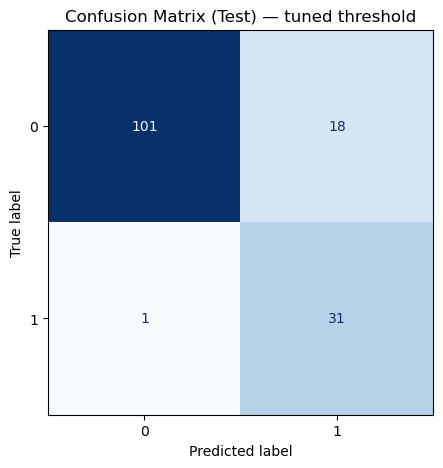

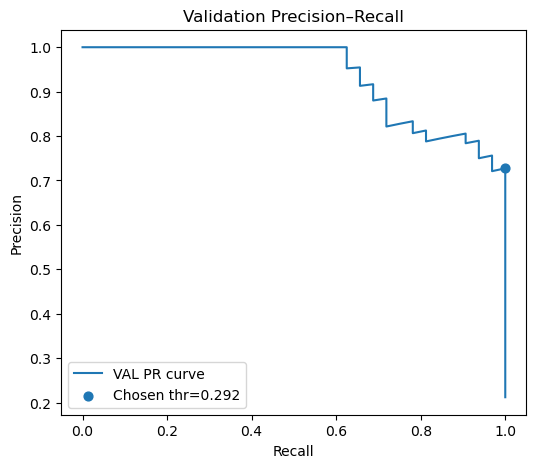

In [5]:
# =========================
# 1) Helpers
# =========================
def drop_unwanted_cols(df):
    """Drop CSV index artifacts like 'Unnamed: 0', etc."""
    return df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], errors="ignore")

def clean_target(series, drop_unmapped=True):
    """
    Normalize Fraud labels and handle weird/missing entries.
    Returns (clean_int_series, keep_mask).
    """
    s = series.astype(str).str.strip().str.lower()
    mapping = {
        "no": 0, "0": 0, "false": 0, "f": 0, "n": 0,
        "yes": 1, "1": 1, "true": 1, "t": 1, "y": 1
    }
    y = s.map(mapping)
    unmapped_mask = y.isna()
    if unmapped_mask.any():
        print("Unmapped Fraud values:", sorted(s[unmapped_mask].unique()))
        if drop_unmapped:
            print(f"Dropping {unmapped_mask.sum()} rows with unmapped/NA Fraud.")
            keep_mask = ~unmapped_mask
            return y.loc[keep_mask].astype(int), keep_mask
        else:
            # Fill unmapped with majority class from remaining mapped values
            maj = int((y == 1).sum() < (y == 0).sum())
            y = y.fillna(maj)
    keep_mask = pd.Series(True, index=y.index)
    return y.astype(int), keep_mask

def make_splits_clean(train_df, val_df, test_df):
    """Apply consistent cleaning to each split and return X/y for train/val/test."""
    out = {}
    for name, df in [("train", train_df.copy()), ("val", val_df.copy()), ("test", test_df.copy())]:
        df = drop_unwanted_cols(df)

        # Drop leakage column if present (FraudType reveals the label)
        if "FraudType" in df.columns:
            df.drop(columns=["FraudType"], inplace=True)

        # Clean/normalize the target
        y_clean, keep_mask = clean_target(df["Fraud"], drop_unmapped=True)
        df = df.loc[keep_mask].copy()
        df["Fraud"] = y_clean

        # Split X/y
        X = df.drop(columns=["Fraud"])
        y = df["Fraud"]
        out[name] = (X, y)

    (X_train, y_train), (X_val, y_val), (X_test, y_test) = out["train"], out["val"], out["test"]
    print("Class balance after cleaning:",
          {"train": y_train.value_counts().to_dict(),
           "val": y_val.value_counts().to_dict(),
           "test": y_test.value_counts().to_dict()})
    return X_train, y_train, X_val, y_val, X_test, y_test

def infer_columns(X_train):
    """Infer numeric vs categorical by dtype, and force ID-like columns to categorical."""
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_train.columns if c not in num_cols]

    # Force ID-like fields to categorical even if numeric-coded
    force_cats = [c for c in ["ProviderNPI", "ClaimID", "PatientID"] if c in X_train.columns]
    for c in force_cats:
        if c in num_cols:
            num_cols.remove(c)
        if c not in cat_cols:
            cat_cols.append(c)

    print("Numeric cols:", num_cols)
    print("Categorical cols:", cat_cols)
    return num_cols, cat_cols

def tune_threshold(y_true, y_proba, beta=2.0, min_precision=None):
    """
    Return threshold that maximizes F-beta (recall-heavy if beta>1),
    or highest recall subject to min_precision if provided.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)

    if min_precision is not None:
        mask = precisions >= min_precision
        if np.any(mask):
            idx = np.where(mask)[0][np.argmax(recalls[mask])]
            return float(thresholds[idx]), float(precisions[idx]), float(recalls[idx])

    fb = (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls + 1e-9)
    idx = int(np.nanargmax(fb))
    return float(thresholds[idx]), float(precisions[idx]), float(recalls[idx])

# =========================
# 2) Clean data & build columns
#    (Assumes you already have train_df, val_df, test_df in memory)
# =========================
X_train, y_train, X_val, y_val, X_test, y_test = make_splits_clean(train_df, val_df, test_df)
num_cols, cat_cols = infer_columns(X_train)

# =========================
# 3) Preprocessing + Model pipeline
# =========================
transformers = []
if num_cols:
    transformers.append((
        "num",
        Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]),
        num_cols
    ))
if cat_cols:
    transformers.append((
        "cat",
        Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]),
        cat_cols
    ))

preproc = ColumnTransformer(transformers=transformers, remainder="drop")

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced")),
])

# =========================
# 4) Hyperparam search (PR-AUC)
# =========================
param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": np.logspace(-3, 2, 10),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # PR-AUC (better for rare positives)
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    error_score="raise",
)

search.fit(X_train, y_train)
best_pipe = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best PR-AUC:", search.best_score_)

# =========================
# 5) Fit on TRAIN+VAL, threshold-tune on VAL, evaluate on TEST
# =========================
best_pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Tune threshold on VAL for higher recall (F2). You can use min_precision=0.4 if you want a floor.
val_proba = best_pipe.predict_proba(X_val)[:, 1]
thr, P_at_thr, R_at_thr = tune_threshold(y_val, val_proba, beta=2.0, min_precision=None)
print(f"Tuned threshold (VAL): {thr:.3f} | Precision={P_at_thr:.3f} Recall={R_at_thr:.3f}")

# Test eval at tuned threshold
test_proba = best_pipe.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= thr).astype(int)

print("\n=== TEST (tuned threshold) ===")
print("PR-AUC:", average_precision_score(y_test, test_proba))
print("ROC-AUC:", roc_auc_score(y_test, test_proba))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred, digits=4))

cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5.5, 5))
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=False)
ax.set_title("Confusion Matrix (Test) — tuned threshold")
plt.show()

# =========================
# 6) Optional: show VAL PR curve with chosen operating point
# =========================
prec, rec, thr_grid = precision_recall_curve(y_val, val_proba)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label="VAL PR curve")
plt.scatter(R_at_thr, P_at_thr, s=40, label=f"Chosen thr={thr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Validation Precision–Recall")
plt.legend()
plt.show()



In [6]:
import joblib
import os

# Save the trained pipeline locally
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(best_pipe, os.path.join(model_dir, "model.joblib"))

print("Model saved to", os.path.join(model_dir, "model.joblib"))

Model saved to model/model.joblib


In [13]:
%%writefile inference.py
import joblib
import os
import json
import pandas as pd

# Load the trained model
def model_fn(model_dir):
    return joblib.load(os.path.join(model_dir, "model.joblib"))

# Parse input data
EXPECTED_COLUMNS = [
    'TotalCharge', 'NumLines', 'AvgLineCharge', 'MaxLineCharge',
    'ProviderClaimCount', 'HasHighEM', 'HasImaging', 'HasLabOnly',
    'ChargeZScore', 'PatientID', 'ServiceDateFrom', 'ServiceDateTo',
    'ProviderNPI', 'ClaimID'
]

def input_fn(request_body, request_content_type):
    if request_content_type == "application/json":
        data = json.loads(request_body)
        df = pd.DataFrame(data)
        # Add any missing columns
        for col in EXPECTED_COLUMNS:
            if col not in df.columns:
                df[col] = None
        # Ensure correct order
        df = df[EXPECTED_COLUMNS]
        return df
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

# Make predictions
def predict_fn(input_data, model):
    # Return probabilities for class 1 (fraud)
    return model.predict_proba(input_data)[:, 1].tolist()

# Format output
def output_fn(prediction, content_type):
    if content_type == "application/json":
        return json.dumps(prediction)
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

Overwriting inference.py


In [14]:
import sagemaker

bucket_name = 'medi-sagemaker-fraud-detection'  # Ensure this bucket exists in your account
prefix = "fraud-model"

# Upload local model directory to S3
model_artifact = sagemaker.Session().upload_data(
    path=model_dir,
    bucket=bucket_name,
    key_prefix=prefix
)

print(f"Model artifact uploaded to: {model_artifact}")

Model artifact uploaded to: s3://medi-sagemaker-fraud-detection/fraud-model


In [15]:
import joblib
import os
import tarfile
import sagemaker

# 1. Save model locally
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(best_pipe, os.path.join(model_dir, "model.joblib"))

# 2. Create tar.gz archive
tar_path = "model.tar.gz"
with tarfile.open(tar_path, "w:gz") as tar:
    tar.add(os.path.join(model_dir, "model.joblib"), arcname="model.joblib")

print(f"Created tar.gz: {tar_path}")

# 3. Upload tar.gz to S3
bucket_name = 'medi-sagemaker-fraud-detection'
prefix = "fraud-model"
model_artifact = sagemaker.Session().upload_data(
    path=tar_path,
    bucket=bucket_name,
    key_prefix=prefix
)

print(f"Model artifact uploaded to: {model_artifact}")

Created tar.gz: model.tar.gz
Model artifact uploaded to: s3://medi-sagemaker-fraud-detection/fraud-model/model.tar.gz


In [16]:
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import get_execution_role
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

role = get_execution_role()

# Create SKLearnModel pointing to tar.gz in S3
sklearn_model = SKLearnModel(
    entry_point="inference.py",   # Your inference script
    role=role,
    model_data=model_artifact,    # Now points to tar.gz, not .joblib
    framework_version="1.2-1",    # Closest supported version
    sagemaker_session=sagemaker.Session()
)

endpoint_name = "fraud-detection-endpoint-v5"  # Unique name
predictor = sklearn_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print(f"Endpoint deployed: {endpoint_name}")

------!Endpoint deployed: fraud-detection-endpoint-v5


In [17]:
# Take a few rows from your test set
test_sample = X_test.iloc[:5].to_dict(orient="records")
# Send them to the endpoint
response = predictor.predict(test_sample)
print("Predicted fraud probabilities:", response)

Predicted fraud probabilities: [7.994787400170637e-05, 0.007638388532109916, 0.0003038909426655169, 0.08331701001145074, 0.011384830352194387]


In [20]:
import boto3

# Name of your endpoint
endpoint_name = "fraud-detection-endpoint-v3-test"

# CloudWatch log group for SageMaker endpoints
log_group_name = f"/aws/sagemaker/Endpoints/{endpoint_name}"

logs_client = boto3.client("logs", region_name="us-east-1")

# Get the most recent log stream
streams = logs_client.describe_log_streams(
    logGroupName=log_group_name,
    orderBy="LastEventTime",
    descending=True,
    limit=1
)

if not streams.get("logStreams"):
    print("No log streams found for this endpoint.")
else:
    log_stream_name = streams["logStreams"][0]["logStreamName"]
    print(f"Fetching logs from: {log_stream_name}\n")

    # Get the last 50 log events
    events = logs_client.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=False
    )

    for event in events["events"]:
        print(event["message"])

Fetching logs from: AllTraffic/i-0eac4e42ec2b00324

/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-17 21:15:08,053 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2025-10-17 21:15:08,056 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2025-10-17 21:15:08,057 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
   

In [12]:
payload = [
    {
        "TotalCharge": 1000,
        "NumLines": 3,
        "AvgLineCharge": 333.3,
        "MaxLineCharge": 500,
        "ProviderClaimCount": 12,
        "HasHighEM": 1,
        "HasImaging": 0,
        "HasLabOnly": 1,
        "ChargeZScore": 0.5,
        "PatientID": "P123",
        "ServiceDateFrom": "2024-01-01",
        "ServiceDateTo": "2024-01-02",
        "ProviderNPI": "NPI123",
        "ClaimID": "CLM456"
    }
]

response = predictor.predict(payload)
print(response)

[0.035545254425280844]
